<a href="https://colab.research.google.com/github/cu2mauro/NN_matlab_bubble/blob/colabwork/ColabCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network to classify MATLAB bubble results

To build, train and test the CNN we use keras with the tensorflow backend.
Below we import the necessary modules.

In [117]:
import numpy as np #numerical
import pandas as pd #data analysis
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import scipy.io as sio
from scipy import interpolate
import sys
%matplotlib inline
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from os.path import dirname, join as pjoin

In [88]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load dataset: vectors of control points in X, actions in y.

In [111]:
mat = sio.loadmat('/content/drive/MyDrive/NN/NNtot')
data = mat['results']
X = np.reshape(np.vstack(data[:,0][:]),(len(data),12))
y = np.vstack(data[:,3][:])
X = np.reshape(np.c_[np.zeros(len(y)),X,np.zeros(len(y))],(len(y),2,7)) # add zeros for first X and last Y coordinates, reshape

In [112]:
print(X.shape,y.shape)

(3501, 2, 7) (3501, 1)


Divide dataset into training (80%), validation (10%) and test set (10%)



In [120]:
Ntot = len(X)
tot_ind = np.arange(Ntot)
random.shuffle(tot_ind)
val_ind = tot_ind[int(Ntot*0.8):int(Ntot*0.9)]
train_ind = tot_ind[0:int(Ntot*0.8)]
test_ind = tot_ind[int(Ntot*0.9):]

In [121]:
X_train = X[train_ind]
y_train = y[train_ind]
X_val = X[val_ind]
y_val = y[val_ind]
X_test = X[test_ind]
y_test = y[test_ind]

In [122]:
X_train.shape

(2800, 2, 7)

Build the CNN, compile and train/validate it

In [ ]:
model = Sequential()
model.add(Conv2D(2, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 2)         152       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 2)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 4)         204       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 4)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 8)           808       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 8)         

**Note:** training should be done on GPUs, if you are not running on GPUs skip this part and load the pretrained model

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

cnn_history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
39/39 [==============================] - 12s 27ms/step - loss: 1.0295 - accuracy: 0.4701 - val_loss: 0.9638 - val_accuracy: 0.4700
Epoch 2/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9923 - accuracy: 0.4687 - val_loss: 0.9684 - val_accuracy: 0.4700
Epoch 3/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9913 - accuracy: 0.4697 - val_loss: 0.9572 - val_accuracy: 0.4700
Epoch 4/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9891 - accuracy: 0.4585 - val_loss: 0.9626 - val_accuracy: 0.4700
Epoch 5/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9819 - accuracy: 0.4632 - val_loss: 0.9505 - val_accuracy: 0.4700
Epoch 6/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9700 - accuracy: 0.4567 - val_loss: 0.9314 - val_accuracy: 0.4700
Epoch 7/30
39/39 [==============================] - 0s 9ms/step - loss: 0.9490 - accuracy: 0.4685 - val_loss: 0.9137 - val_accuracy: 0.4700
Epoch 8/30
39/39 [

In [ ]:
model = load_model('/content/drive/MyDrive/NN_lectures/gal_classification_CNN/pretrained_CNN.h5')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])
y_pred_cnn2 = model.predict(X_test)

Test accuracy: 0.9562398791313171
20/20 [==============================] - 0s 3ms/step


This is a Galaxy with disk edge-on


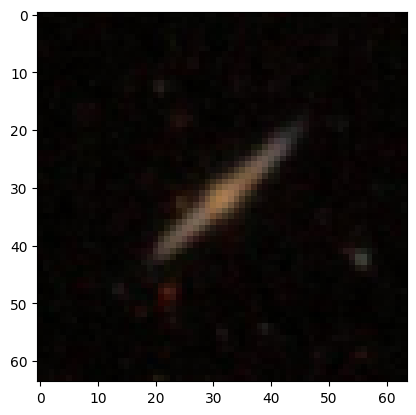

In [ ]:
t = np.random.randint(len(X_test))
plt.imshow(X_test[t, :, :]*255)
print_class(y_pred_cnn2[t])

Save and reload the trained model

In [ ]:
#model.save('pretrained_CNN.h5')
#model = load_model('pretrained_CNN.h5')
#model = load_model('/content/drive/MyDrive/NN_SISSA_2022/gal_classification_CNN/pretrained_CNN.h5')

some inspection...

we extract from the trained neural network the values of weights in each filter and plot them

In [ ]:
conv1_lyr = model.layers[0]

In [ ]:
w_conv1 = conv1_lyr.get_weights()

In [ ]:
w_conv1 = np.array(w_conv1)

<ipython-input-30-00f81d5ecc60>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_conv1 = np.array(w_conv1)


In [ ]:
w_conv1[0].shape

(5, 5, 3, 16)

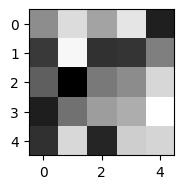

In [ ]:
plt.subplot(132)
plt.imshow(w_conv1[0][:,:,0,1], cmap='binary')